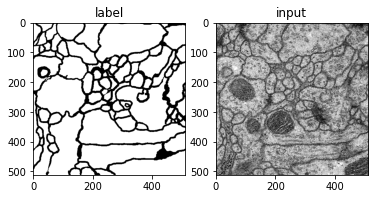

In [1]:
## 필요한 패키지 등록
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## 데이터 불러오기
dir_data = 'C:/Users/user/Desktop/data/isbi-2012/data'

name_label = 'train-labels.tif'
name_input = 'train-volume.tif'

img_label = Image.open(os.path.join(dir_data, name_label))
img_input = Image.open(os.path.join(dir_data, name_input))

ny, nx = img_label.size
nframe = img_label.n_frames

##
nframe_train = 24
nframe_val = 3
nframe_test = 3

dir_save_train = os.path.join(dir_data, 'train')
dir_save_val = os.path.join(dir_data, 'val')
dir_save_test = os.path.join(dir_data, 'test')

if not os.path.exists(dir_save_train):
    os.makedirs(dir_save_train)

if not os.path.exists(dir_save_val):
    os.makedirs(dir_save_val)

if not os.path.exists(dir_save_test):
    os.makedirs(dir_save_test)

##
id_frame = np.arange(nframe)
np.random.shuffle(id_frame)

##
offset_nframe = 0

for i in range(nframe_train):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_train, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_train, 'input_%03d.npy' % i), input_)

##
offset_nframe = nframe_train

for i in range(nframe_val):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_val, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_val, 'input_%03d.npy' % i), input_)

##
offset_nframe = nframe_train + nframe_val

for i in range(nframe_test):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_test, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_test, 'input_%03d.npy' % i), input_)

##
plt.subplot(121)
plt.imshow(label_, cmap='gray')
plt.title('label')

plt.subplot(122)
plt.imshow(input_, cmap='gray')
plt.title('input')

plt.show()

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms, datasets

In [4]:
# training parameter ##
lr = 1e-3
batch_size = 4
num_epoch = 100

data_dir = 'C:/Users/user/Desktop/data/isbi-2012/data'
ckpt_dir = './checkpoint'
log_dir ='./log'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
device

device(type='cuda')

In [5]:
torch.cuda.is_available()

True

In [6]:
## 네트워크 구축하기 ##
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr
        #UNET 기준으로 좌측은 Encoder를 의미한다
        #enc1_1은 encoder의 1stage의 1번째 단계.
        # Contracting path
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        
        #다음 스테이지로 넘어갈때 maxpooling을 해준다
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        
        #여기서부턴 Decoder 부분.
        # Encoder의 pooling 부분과 매칭을 하기위해 unpooling이라고 정의
        # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)
        ## 
        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [7]:
import os
import numpy as np

import torch
import torch.nn as nn

## 데이터 로더를 구현하기
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]

        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        label = label/255.0
        input = input/255.0

        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input, 'label': label}

        if self.transform:
            data = self.transform(data)

        return data

In [8]:
#test
dataset_train = Dataset(data_dir=os.path.join(data_dir,'train'))

In [9]:
data = dataset_train.__getitem__(0)

In [10]:
input = data['input']
label =data['label']

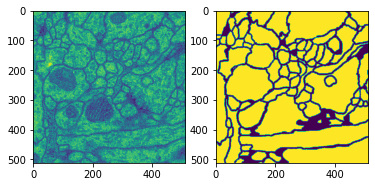

In [11]:
plt.subplot(121)
plt.imshow(input)
plt.subplot(122)
plt.imshow(label)
plt.show()

In [12]:
# label, input의 형태

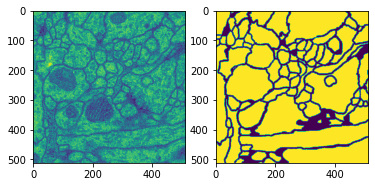

In [13]:
plt.subplot(121)
plt.imshow(input.squeeze())
plt.subplot(122)
plt.imshow(label.squeeze())
plt.show()

In [14]:
## 트랜스폼 구현하기
# numpy -> tensor

#numpy는(y,x,ch)형태지만 pytorch는(ch,y,x)형태이다

class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std

        data = {'label': label, 'input': input}

        return data

class RandomFlip(object):   ##임의로 잘라내기
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label) #lr은 left right
            input = np.fliplr(input)

        if np.random.rand() > 0.5:
            label = np.flipud(label) #ud 는 up down
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data
        

In [15]:
transform = transforms.Compose([Normalization(mean=0.5, std=0.5),RandomFlip(),ToTensor()])

dataset_train=Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)

In [16]:
data = dataset_train.__getitem__(0)
input = data['input']
label = data['label']

In [28]:
input.shape

torch.Size([1, 512, 512])

In [29]:
input.type()

'torch.FloatTensor'

In [17]:
# 네트워크 저장하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
        
    torch.save({'net':net.state_dict(), 'optim':optim.state_dict()},
               "./%s/model_epoch%d.pth"%(ckpt_dir,epoch))
    
# 네트워크 불러오기
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch=0
        return net, optim, epoch
    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    
    dict_model = torch.load('./%s/%s' %(ckpt_dir, ckpt_lst[1]))
    
    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])
    
    return net, optim, epoch

In [18]:
## Training ##
transform = transforms.Compose([Normalization(mean=0.5, std=0.5),RandomFlip(),ToTensor()])

## Dataloader ##
dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)
loader_train = DataLoader(dataset_train, batch_size =batch_size, shuffle=True, num_workers=1)

dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=transform)
loader_val = DataLoader(dataset_val, batch_size =batch_size, shuffle=False, num_workers=1)

## network 생성 ##
net = UNet().to(device)

## 손실함수 정의하기

fn_loss = nn.BCEWithLogitsLoss().to(device)

## optimizer
optim = torch.optim.Adam(net.parameters(), lr=lr)

## Variables

num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

num_batch_train = np.ceil(num_data_train/batch_size)
num_batch_val = np.ceil(num_data_val/batch_size)

## Functions
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0,2,3,1)
fn_denorm = lambda x, mean, std : (x*std)+mean
fn_clss = lambda x: 1.0*(x>0.5)

## Tensorboard를 사용하기 위한 Summary Writer

writer_train = SummaryWriter(log_dir=os.path.join(log_dir,'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir,'val'))

## Network Training
st_epoch=0
net, optim, st_epoch = load(ckpt_dir = ckpt_dir, net=net, optim=optim)


for epoch in range(st_epoch +1, num_epoch+1):
    net.train()
    loss_arr=[]
    
    for batch, data in enumerate(loader_train, 1):
        #forward pass
        label = data['label'].to(device)
        input = data['input'].to(device)
        output = net(input)
        #backward pass
        optim.zero_grad()
        
        loss= fn_loss(output, label)
        loss.backward()
        
        optim.step()
        
        ## 손실함수 계산
        loss_arr += [loss.item()]
        print("TRAIN : EPOCH %04d/ %04d | BATCH %04d / %04d | LOSS %.4f"%
              (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))
        
        ## Tensorboard 저장
        label =fn_tonumpy(label)
        input =fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
        output = fn_tonumpy(fn_class(output))
        
        writer_train.add_image('label', label, num_batch_train * (epoch-1) + batch, dataformats='NHWC')
        writer_train.add_image('input', input, num_batch_train * (epoch-1) + batch, dataformats='NHWC')
        writer_train.add_image('output', output, num_batch_train * (epoch-1) + batch, dataformats='NHWC')
        
    writer_train.add_scalar('loss', np.mean(loss_arr),epoch)
    
    
    with torch.no_grad():
        net.eval()
        loss_arr = []
        
        for batch,data in enumerate(loader_val, 1):
            #forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)
            output = net(input)
            
            #손실함수 계산하기
            loss = fn_loss(output,label)
            loss_arr +=[loss.item()]
            
            print("TRAIN : EPOCH %04d/ %04D | BATCH %04d / %04d | LOSS %.4f"%
              (epoch, num_epoch, batch, num_batch_val, np.mean(loss_arr)))
            
            #Tensorboard 저장하기
            
            label = fn_tonumpy(label)
            input = fn_tonumpy(fn_denorm(input))
            output = fn_tonumpy(fn_class(output))
            
            writer_val.add_image('label', label, num_batch_val * (epoch-1) + batch, dataformats='NHWC')
            writer_val.add_image('input', input, num_batch_val * (epoch-1) + batch, dataformats='NHWC')
            writer_val.add_image('output', output, num_batch_val * (epoch-1) + batch, dataformats='NHWC')
            
    writer_val.add_scalar('loss', np.mean(loss_arr), epoch)
    
    if epoch % 5 ==0 : # 5에폭 마다 모델저장해주기
        save(ckpt_dir =ckpt_dir, net=net, optim=optim, epoch=epoch)

writer_train.close()
writer_val.close()

RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 6.00 GiB total capacity; 4.16 GiB already allocated; 194.50 MiB free; 4.18 GiB reserved in total by PyTorch)